In [3]:
import math
import os
import sys

from dataclasses import asdict, dataclass, field
from typing import Any, Dict, Optional

import datasets
import torch
import transformers
from datasets import interleave_datasets, load_dataset, load_from_disk

from transformers import HfArgumentParser, TrainingArguments, ViTFeatureExtractor

In [2]:
from pixel import (
    PIXELConfig,
    PIXELEmbeddings,
    PIXELModel,
    PIXELForPreTraining,
    PIXELTrainerForPretraining,
    SpanMaskingGenerator,
    PyGameTextRenderer,
    get_attention_mask,
    get_transforms,
    get_2d_sincos_pos_embed
)
from transformers.modeling_outputs import (
    BaseModelOutput)
from torch import nn

In [1]:
from pixel import BartForConditionalGeneration, PIXELModel

/work/sc118/sc118/xliao11/miniconda3/envs/pixel-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from pixel import PangoCairoTextRenderer

/work/sc118/sc118/xliao11/miniconda3/envs/pixel-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test PangoCairoTextRender

In [2]:
processor = PangoCairoTextRenderer.from_pretrained(
    'new_configs/panga/'
)

In [7]:
text = "This is a sentence"

In [16]:
encoding =processor(text=text)
img = Image.fromarray(encoding.pixel_values)
attention_mask = get_attention_mask(
        num_text_patches=encoding.num_text_patches, seq_length=processor.max_seq_length
    )
imgs = transforms(Image.fromarray(encoding.pixel_values)).unsqueeze(0)
attention_mask = attention_mask.unsqueeze(0)
#labels = model.patchify(imgs)
decoder_attention_mask = attention_mask

In [21]:
imgs.shape

torch.Size([1, 1, 8, 4232])

### get dataset

In [4]:
train_dataset = load_from_disk("../cache/datasets/interleave_8x8_eval")

config

In [38]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_grey'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "vocab_size": 192,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
    
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_grey were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
image_height = text_renderer.pixels_per_patch
image_width = text_renderer.pixels_per_patch * text_renderer.max_seq_length
column_names = ["pixel_values", "text", "num_patches"]
image_column_name = column_names[0]


image_mean, image_std = (None, None)
feature_extractor.do_normalize = False

# Set transformations --- resize by default and optionally apply normalization
transforms = get_transforms(
    do_resize=True,
    size=(image_height, image_width),
    do_normalize=False,
    image_mean=image_mean,
    image_std=image_std,
)

def patchify(imgs):
    """
    imgs: (N, 3, H, W) x: (N, L, patch_size**2 *3)
    """
    """
    imgs: (3, H, W) x: (L, patch_size**2 *3)
    """
    p = imgs.shape[1]
    assert imgs.shape[1] % p == 0 and imgs.shape[2] % p == 0

    h = imgs.shape[1] // p
    w = imgs.shape[2] // p
    x = imgs.reshape(shape=(3, h, p, w, p))
    x = torch.einsum("chpwq->hwpqc", x)
    x = x.reshape(shape=( h * w, p ** 2 * 3))

    return x

def preprocess_images(examples):
    """Preprocess a batch of images by applying transforms."""

    examples["input_ids"] = [transforms(image) for image in examples[image_column_name]]
    examples["attention_mask"] = [get_attention_mask(num_patches) for num_patches in examples["num_patches"]]

    examples["labels"] = [patchify(input_id) for input_id in examples['input_ids']] 
    examples["decoder_attention_mask"] = examples["attention_mask"] 

    return examples

In [40]:
train_dataset.set_transform(preprocess_images)
input = train_dataset[:5]

print("pixel_values:")
print(torch.stack(input["input_ids"]).shape)
print("attention_mask:")
print(torch.stack(input["attention_mask"]).shape)
print("labels:")
print(torch.stack(input["labels"]).shape)
print("decoder_attention_mask:")
print(torch.stack(input["decoder_attention_mask"]).shape)

imgs = torch.stack(input["input_ids"])
attention_mask = torch.stack(input["attention_mask"])
labels = torch.stack(input["labels"])
decoder_attention_mask = torch.stack(input["decoder_attention_mask"])


pixel_values:
torch.Size([5, 3, 8, 4232])
attention_mask:
torch.Size([5, 529])
labels:
torch.Size([5, 529, 192])
decoder_attention_mask:
torch.Size([5, 529])


### test output

In [41]:
model.eval()
with torch.no_grad():
    outputs = model(
    input_ids = imgs,
    attention_mask=attention_mask,
    labels = labels,
    decoder_attention_mask = decoder_attention_mask,
    head_mask=None,
    output_attentions=True,
    output_hidden_states=True,
    return_dict=True,
    )

predictions = unpatchify(outputs["logits"]).detach().cpu()


In [20]:
labels[0].shape

torch.Size([529, 192])

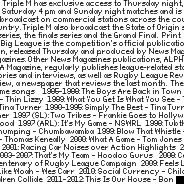

In [42]:
get_image(unpatchify(labels)[1])

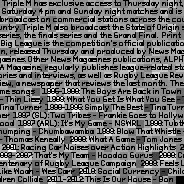

In [43]:
get_image(predictions[1])

### visual

In [4]:
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision


def unpatchify( x):
    """
    x: (N, L, patch_size**2 *3) imgs: (N, 3, H, W) -> H = 1, W = seq_len
    """
    p = model.model.vit.embeddings.patch_embeddings.patch_size[0]
    h = w = int(x.shape[1] ** 0.5)
    c = model.config.num_channels
    assert h * w == x.shape[1]

    x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
    x = torch.einsum("nhwpqc->nchpwq", x)
    imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
    return imgs
def clip(x: torch.Tensor):
    x = torch.einsum("chw->hwc", x)
    x = torch.clip(x * 10, 0, 10)
    x = torch.einsum("hwc->chw", x)
    return x
def get_image(img: torch.Tensor, do_clip: bool = True):
    if do_clip:
        img = clip(img)
    img = torchvision.utils.make_grid(img, normalize=True)
    image = Image.fromarray(
        img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    )
    return image

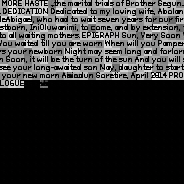

In [12]:
get_image(predictions[0])

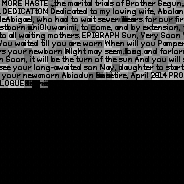

In [18]:
# 10000steps
get_image(predictions[0])

## generate

takeaway：\
最后的那个checkpoints并不一定是最好的，横向对比一下 \
best: grey(85000), binary(85000)
w/o prompt/ between checkpoints

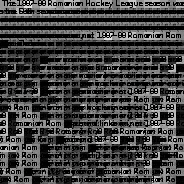

In [45]:
logits, past, loss =model.generate(input_ids=imgs, attention_mask=attention_mask, labels = labels, decoder_attention_mask = decoder_attention_mask)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

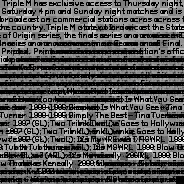

In [46]:
get_image(gen[1])

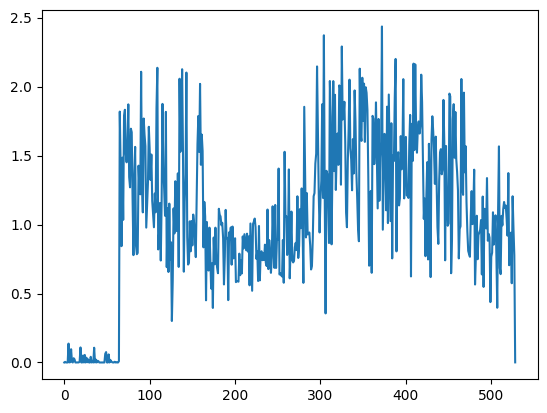

In [48]:
import matplotlib.pyplot as plt

plt.plot(loss[1])

#### 30000

In [440]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_grey/checkpoint-30000/'
#text_renderer = PyGameTextRenderer.from_pretrained("new_configs")
#feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "vocab_size": 192,
        }
)


model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
    
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_grey/checkpoint-30000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


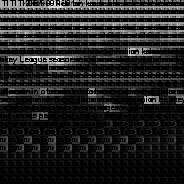

In [441]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

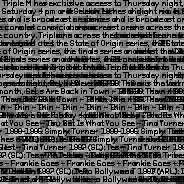

In [442]:
get_image(gen[1])

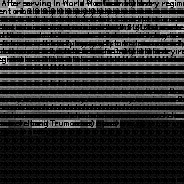

In [443]:
get_image(gen[2])

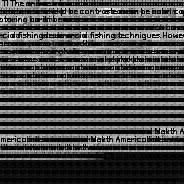

In [444]:
get_image(gen[3])

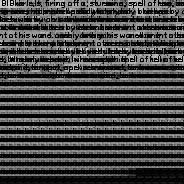

In [445]:
get_image(gen[4])

#### 50000

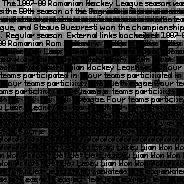

In [329]:
# 50000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

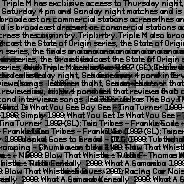

In [330]:
get_image(gen[1])

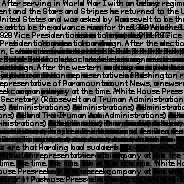

In [331]:
get_image(gen[2])

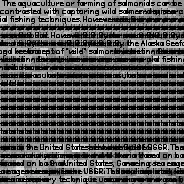

In [332]:
get_image(gen[3])

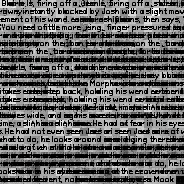

In [333]:
get_image(gen[4])

#### 60000

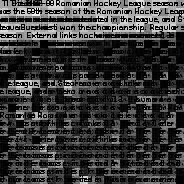

In [321]:
# 60000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

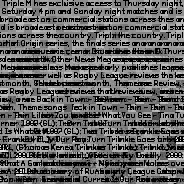

In [323]:
get_image(gen[1])

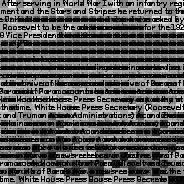

In [324]:
get_image(gen[2])

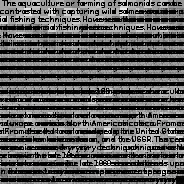

In [325]:
get_image(gen[3])

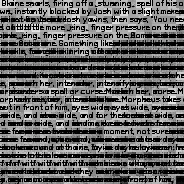

In [326]:
get_image(gen[4])

#### 70000

In [334]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_grey/checkpoint-70000/'
#text_renderer = PyGameTextRenderer.from_pretrained("new_configs")
#feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "vocab_size": 192,
        }
)


model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
    
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_grey/checkpoint-70000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


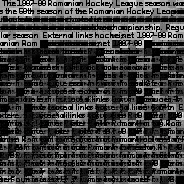

In [335]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

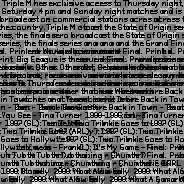

In [336]:
get_image(gen[1])

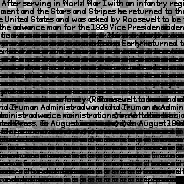

In [337]:
get_image(gen[2])

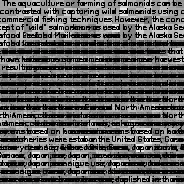

In [338]:
get_image(gen[3])

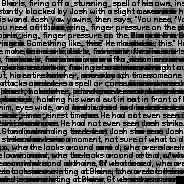

In [339]:
get_image(gen[4])

#### 80000

In [340]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_grey/checkpoint-80000/'
#text_renderer = PyGameTextRenderer.from_pretrained("new_configs")
#feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "vocab_size": 192,
        }
)


model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
    
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_grey/checkpoint-80000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


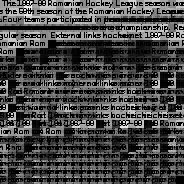

In [341]:
# 80000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

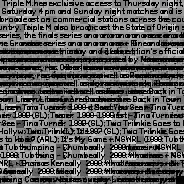

In [342]:
get_image(gen[1])

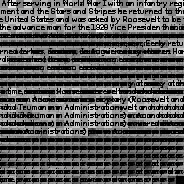

In [343]:
get_image(gen[2])

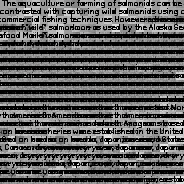

In [344]:
get_image(gen[3])

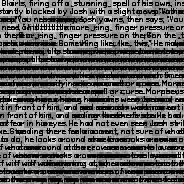

In [345]:
get_image(gen[4])

#### 85000

In [346]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_grey/checkpoint-85000/'
#text_renderer = PyGameTextRenderer.from_pretrained("new_configs")
#feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "vocab_size": 192,
        }
)


model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
    
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_grey/checkpoint-85000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


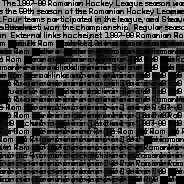

In [347]:
# 85000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

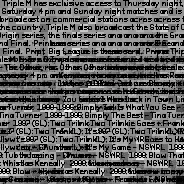

In [348]:
get_image(gen[1])

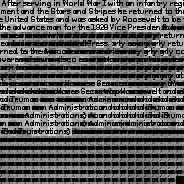

In [352]:
get_image(gen[2])

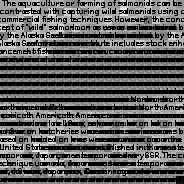

In [350]:
get_image(gen[3])

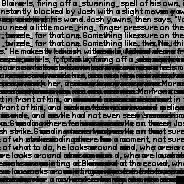

In [351]:
get_image(gen[4])

#### 90000

In [354]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_grey/checkpoint-90000/'
#text_renderer = PyGameTextRenderer.from_pretrained("new_configs")
#feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "vocab_size": 192,
        }
)


model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
    
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_grey/checkpoint-90000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


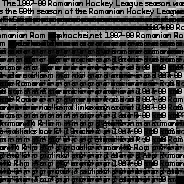

In [355]:
# 90000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

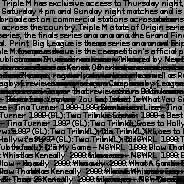

In [357]:
get_image(gen[1])

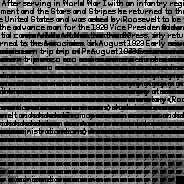

In [358]:
get_image(gen[2])

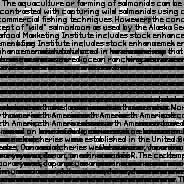

In [359]:
get_image(gen[3])

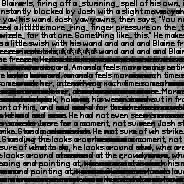

In [360]:
get_image(gen[4])

#### 100000

In [361]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_grey/checkpoint-100000/'
#text_renderer = PyGameTextRenderer.from_pretrained("new_configs")
#feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "vocab_size": 192,
        }
)


model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
    
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_grey/checkpoint-100000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


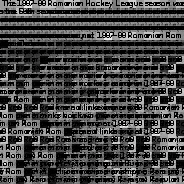

In [362]:
# 90000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

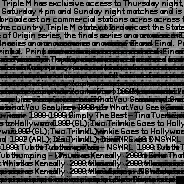

In [363]:
get_image(gen[1])

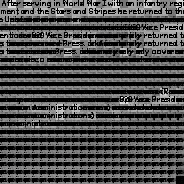

In [364]:
get_image(gen[2])

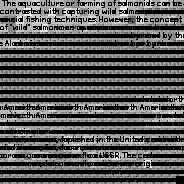

In [365]:
get_image(gen[3])

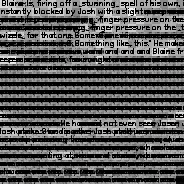

In [366]:
get_image(gen[4])

### add prompt

10

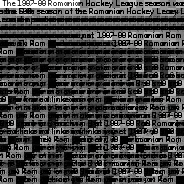

In [47]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=10)
gen10 = unpatchify(logits).detach().cpu()
get_image(gen10[0])

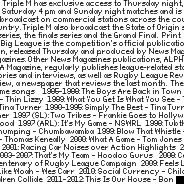

In [33]:
get_image(unpatchify(labels)[1])

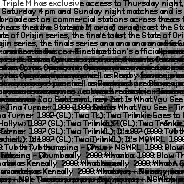

In [32]:
get_image(gen5[1])

20

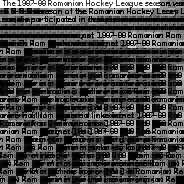

In [45]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=20)
gen20 = unpatchify(logits).detach().cpu()
get_image(gen20[0])

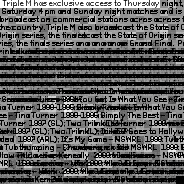

In [46]:
get_image(gen20[1])

5

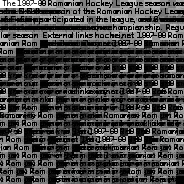

In [44]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask, decoder_input_ids=imgs, prompt_len=5)
gen5 = unpatchify(logits).detach().cpu()
get_image(gen5[0])

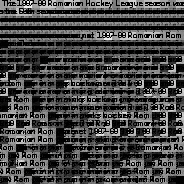

In [41]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

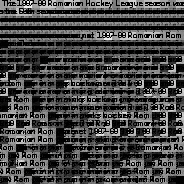

In [43]:
get_image(gen[0])

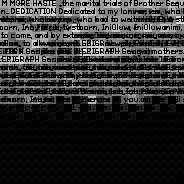

In [67]:
get_image(gen[0])

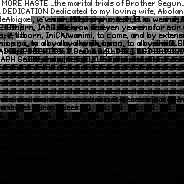

In [64]:
get_image(gen[0])

In [12]:
logits.shape

torch.Size([2, 529, 192])

In [ ]:
sos_token = nn.Parameter(torch.zeros(1, 1, 192))
sos_img = model.unpatchify(sos_token)
sos_emb = model.model.vit.embeddings.patch_embeddings\
    .projection(sos_img).flatten(2).transpose(1, 2)


In [ ]:
sos_emb.shape

torch.Size([1, 1, 768])

In [16]:
# prepare encoder_outputs
encoder_outputs = model.model.vit(
    pixel_values= imgs,
    attention_mask = attention_mask,
)
encoder_outputs = BaseModelOutput(
    last_hidden_state=encoder_outputs.last_hidden_state,
    hidden_states=encoder_outputs.hidden_states,
    attentions=encoder_outputs.attentions,
)

In [62]:

sos_token = nn.Parameter(torch.zeros(1, 2, 768))
sos_token = sos_token.expand(imgs.shape[0], -1, -1)

outputs = model(
    encoder_outputs = encoder_outputs,
    decoder_inputs_embeds = sos_token,
    use_cache = True
)

## Binary

### adjustments of the model

In [6]:
'''
# Adjust image size for BART
image_height = text_renderer.pixels_per_patch
image_width = text_renderer.pixels_per_patch * text_renderer.max_seq_length
model.config.image_size = (image_height, image_width)
model.config.patch_size = image_height
model.image_size = (image_height, image_width)
feature_extractor.size = (image_height, image_width)
# Reinitialize embeddings


#if data_args.isPixelBinary:
if isBinaryPixel:
model.config.num_channels = 1
model.config.vocab_size = model.config.patch_size **2*model.config.num_channels
model.lm_head = nn.Linear(model.config.hidden_size, config.vocab_size, bias=False)
model.model.vit.embeddings = PIXELEmbeddings(model.config)
else:
model.model.vit.embeddings = PIXELEmbeddings(model.config)
'''


In [5]:
from torchvision.transforms import Compose, InterpolationMode, Lambda, Normalize, Resize, ToTensor
#if data_args.isPixelBinary:
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart_BSZ128_binary')
isBinaryPixel = True
if isBinaryPixel:
    transforms = Compose([
        Resize(feature_extractor.size, interpolation=InterpolationMode.BICUBIC),
        ToTensor(),
        lambda x: x>=1,
        lambda x: x.float(),])
else:
    image_mean, image_std = (None, None)
    feature_extractor.do_normalize = False

    # Set transformations --- resize by default and optionally apply normalization
    transforms = get_transforms(
        do_resize=True,
        size=(image_height, image_width),
        do_normalize=False,
        image_mean=image_mean,
        image_std=image_std,
    )
    

In [6]:
column_names = ["pixel_values", "text", "num_patches"]
image_column_name = column_names[0]
def patchify(imgs):
    """
    imgs: (N, 3, H, W) x: (N, L, patch_size**2 *3)
    """
    """
    imgs: (3, H, W) x: (L, patch_size**2 *3)
    """
    p = imgs.shape[1]
    c = 1
    assert imgs.shape[1] % p == 0 and imgs.shape[2] % p == 0

    h = imgs.shape[1] // p
    w = imgs.shape[2] // p
    x = imgs.reshape(shape=(c, h, p, w, p))
    x = torch.einsum("chpwq->hwpqc", x)
    x = x.reshape(shape=( h * w, p ** 2 * c))

    return x

def preprocess_images(examples):
    """Preprocess a batch of images by applying transforms."""

    examples["input_ids"] = [transforms(image) for image in examples[image_column_name]]
    examples["attention_mask"] = [get_attention_mask(num_patches) for num_patches in examples["num_patches"]]

    examples["labels"] = [patchify(input_id) for input_id in examples['input_ids']] 
    examples["decoder_attention_mask"] = examples["attention_mask"] 

    return examples

In [7]:
train_dataset = load_from_disk("../cache/datasets/interleave_8x8_eval")

In [8]:
train_dataset.set_transform(preprocess_images)
input = train_dataset[:5]

print("pixel_values:")
print(torch.stack(input["input_ids"]).shape)
print("attention_mask:")
print(torch.stack(input["attention_mask"]).shape)
print("labels:")
print(torch.stack(input["labels"]).shape)
print("decoder_attention_mask:")
print(torch.stack(input["decoder_attention_mask"]).shape)

imgs = torch.stack(input["input_ids"])
attention_mask = torch.stack(input["attention_mask"])
labels = torch.stack(input["labels"])
decoder_attention_mask = torch.stack(input["decoder_attention_mask"])

pixel_values:
torch.Size([5, 1, 8, 4232])
attention_mask:
torch.Size([5, 529])
labels:
torch.Size([5, 529, 64])
decoder_attention_mask:
torch.Size([5, 529])


In [23]:
mask_ratio = 0.25
max_span_length = 6
mask_generator = SpanMaskingGenerator(
    num_patches=text_renderer.max_seq_length,
    num_masking_patches=math.ceil(mask_ratio * text_renderer.max_seq_length),
    max_span_length=max_span_length,
    spacing="span"
)
patch_mask = torch.tensor(mask_generator(num_text_patches=(530))).unsqueeze(0)

### Prediction

focal-noise

In [9]:
# for test and visual
model_path = '../experiment/unshuffle/bart_binary_focal_span'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)


# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0.25,
            "decoder_num_hidden_layers": 12,
            "isBinary":True
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

In [25]:
model.eval()
with torch.no_grad():
    outputs, mask = model(
    input_ids = imgs,
    attention_mask=attention_mask,
    labels = labels,
    patch_mask = patch_mask,
    decoder_attention_mask = decoder_attention_mask,
    head_mask=None,
    output_attentions=True,
    output_hidden_states=True,
    return_dict=True,
    )

predictions = unpatchify(outputs["logits"]).detach().cpu()

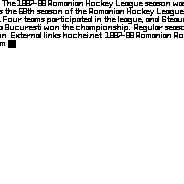

In [11]:
get_image(unpatchify(labels)[0])

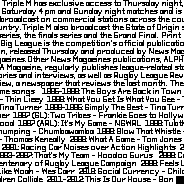

In [12]:
get_image(unpatchify(labels)[1])

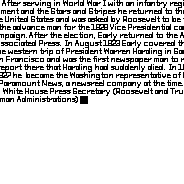

In [13]:
get_image(unpatchify(labels)[2])

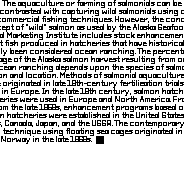

In [26]:
get_image(unpatchify(labels)[3])

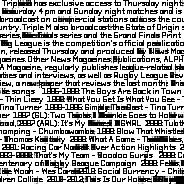

In [23]:
get_image(predictions[1])

In [27]:

ma = mask.unsqueeze(-1).repeat(1, 1, text_renderer.pixels_per_patch ** 2 )
ma = unpatchify(ma).squeeze()  # 1 is removing, 0 is keeping
at = attention_mask.unsqueeze(-1).repeat(1, 1, text_renderer.pixels_per_patch ** 2)
at = unpatchify(at).squeeze()

In [31]:
idx = 3
original_img = unpatchify(labels)[idx]
prediction = predictions[idx]
im_masked = original_img * (1 - (torch.bitwise_and(ma[idx] == 1, at[idx] == 1)).long())

masked_predictions = prediction * ma[idx] * at[idx]

reconstruction = im_masked + masked_predictions

In [33]:
reconstruction.shape,im_masked.shape

(torch.Size([1, 184, 184]), torch.Size([1, 184, 184]))

In [50]:
reconstruction.shape,im_masked.shape

(torch.Size([1, 184, 184]), torch.Size([1, 184, 184]))

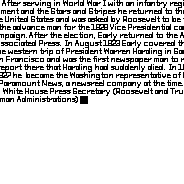

In [25]:
get_image(original_img)

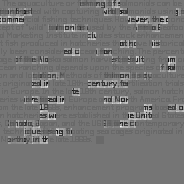

In [32]:
get_image(reconstruction,do_clip=False)

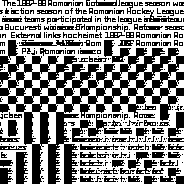

In [30]:
logits, past, loss = model.generate(input_ids=imgs, attention_mask=attention_mask,patch_mask=patch_mask, labels = labels,decoder_attention_mask =decoder_attention_mask )
gen_focal = unpatchify(logits).detach().cpu()
get_image(gen_focal[0])

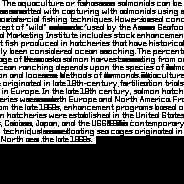

In [35]:
get_image(gen_focal[3]* at[3])

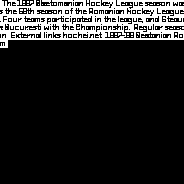

In [12]:
outputs.loss

tensor(5.0137e-07)

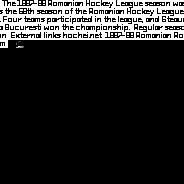

In [13]:
get_image(predictions[0])

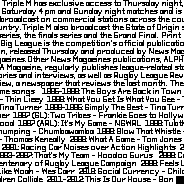

In [19]:
logits, past, loss = model.generate(input_ids=imgs, attention_mask=attention_mask, labels = labels,decoder_attention_mask =decoder_attention_mask )
gen_focal = unpatchify(logits).detach().cpu()
get_image(gen_focal[1])

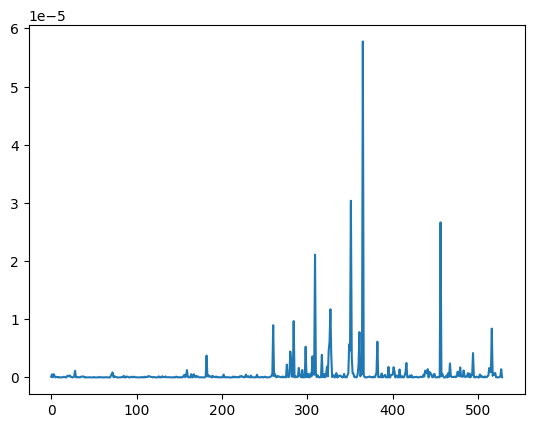

In [22]:
import matplotlib.pyplot as plt

plt.plot(loss[1])

focal

In [27]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary_focal'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)


# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0.25,
            "decoder_num_hidden_layers": 12,
            "isBinary":True
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)
    

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary_focal and are newly initialized: ['model.mask_token']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model.eval()
with torch.no_grad():
    outputs = model(
    input_ids = imgs,
    attention_mask=attention_mask,
    labels = labels,
    decoder_attention_mask = decoder_attention_mask,
    head_mask=None,
    output_attentions=True,
    output_hidden_states=True,
    return_dict=True,
    )

predictions = unpatchify(outputs["logits"]).detach().cpu()

In [29]:
outputs.loss

tensor(0.0564)

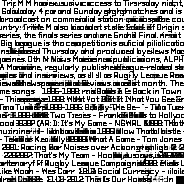

In [30]:
get_image(predictions[1])

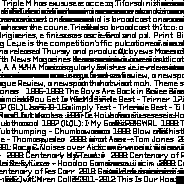

In [31]:
logits, past, loss = model.generate(input_ids=imgs, attention_mask=attention_mask, labels = labels,decoder_attention_mask =decoder_attention_mask )
gen_focal = unpatchify(logits).detach().cpu()
get_image(gen_focal[1])

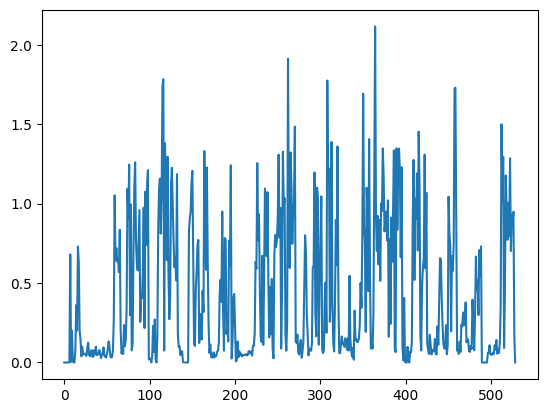

In [32]:
import matplotlib.pyplot as plt

plt.plot(loss[1])

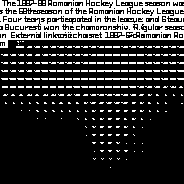

In [40]:
get_image(binary_pred[0])

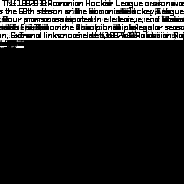

In [30]:
get_image(predictions[0])

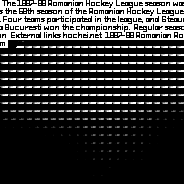

In [14]:
get_image(predictions[0])

In [13]:
logits = outputs["logits"]
logits[0][0]

tensor([ 5.3544,  5.7732, -6.6230, -6.8534, -7.7569, -7.2521, -6.1605, -5.4558,
         7.3696,  6.8568,  5.4168,  6.5958, -5.8666,  8.0590,  7.2266, -5.0721,
         5.4457,  7.2473,  5.7259,  5.5311, -8.7528,  5.9222,  5.8115, -8.1755,
         5.6873,  6.8310,  6.4181,  7.1193, -7.3993,  6.4464,  7.3822, -6.1322,
         6.5342,  6.4793,  6.1564,  6.6168, -7.0058,  6.9585,  6.6775, -6.2656,
         4.6492,  7.2065,  4.7130,  5.8216, -6.2377,  5.5955,  5.7833, -5.6474,
        11.1107,  7.4586,  6.9074,  8.1765,  5.6868,  7.1076,  6.8086,  6.6960,
         7.0064,  5.3641,  5.0426,  5.6188,  4.6907,  4.7758,  4.8923,  4.6070])

In [39]:
binary_pred = (predictions > 0).float()
binary_pred.shape

torch.Size([5, 1, 184, 184])

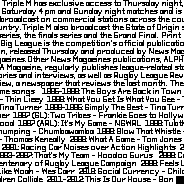

In [18]:
get_image(unpatchify(labels)[1])

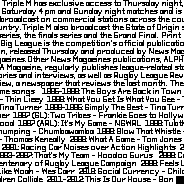

In [22]:
get_image(predictions[1])

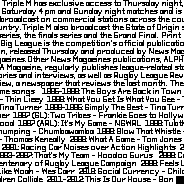

In [17]:
get_image(binary_pred[1])

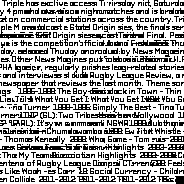

In [48]:
logits, past, loss = model.generate(input_ids=imgs, attention_mask=attention_mask, labels = labels,decoder_attention_mask =decoder_attention_mask )
gen_focal = unpatchify(logits).detach().cpu()
get_image(gen_focal[1])

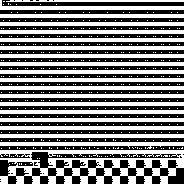

In [21]:
get_image(gen_focal[0])

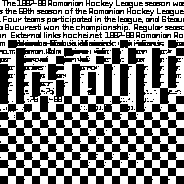

In [30]:
get_image(gen_focal[0])

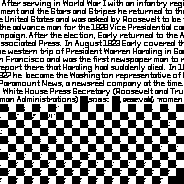

In [31]:
get_image(gen_focal[2])

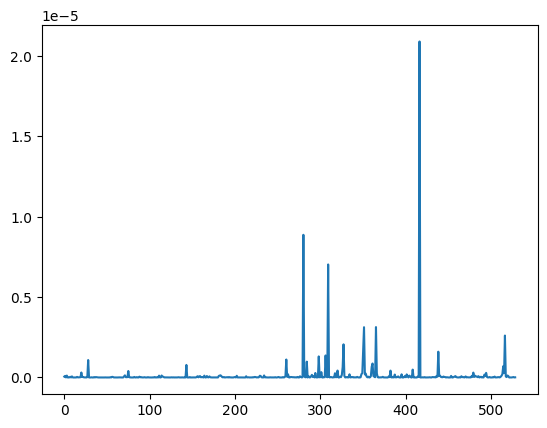

In [25]:
import matplotlib.pyplot as plt

plt.plot(loss[1])

In [ ]:
text = 'The highest accuracy object detectors to date are based on a two-stage approach popularized by R-CNN, where a classifier is applied to a sparse set of candidate object locations. In contrast, one-stage detectors that are applied over a regular, dense sampling of possible object locations have the potential to be faster and simpler, but have trailed the accuracy of two-stage detectors thus far. In this paper, we investigate why this is the case. We discover that the extreme foreground-background class imbalance encountered during training of dense detectors is the central cause. We propose to address this class imbalance by reshaping the standard cross entropy loss such that it down-weights the loss assigned to well-classified examples.'

In [69]:
text = "OCR has become very popular nowadays and has been adopted by several industries for faster text data reading from images. While solutions like contour detection, image classification, connected component analysis, etc. are used for documents that have comparable text size and font, ideal lighting conditions, good image quality, etc., such methods are not effective for irregular, heterogeneous text often called wild text or scene text. This text could be from a car’s license plate, house number plate, poorly scanned documents (with no predefined conditions), etc. For this, Deep Learning solutions are used. Using DL for OCR is a three-step process and these steps are:"

In [70]:
# Try something new

encoding = text_renderer(text=text)
img = Image.fromarray(encoding.pixel_values)
attention_mask = get_attention_mask(
        num_text_patches=encoding.num_text_patches, seq_length=text_renderer.max_seq_length
    )
imgs = transforms(Image.fromarray(encoding.pixel_values)).unsqueeze(0)
attention_mask = attention_mask.unsqueeze(0)
labels = model.patchify(imgs)
decoder_attention_mask = attention_mask

In [71]:
model.eval()
with torch.no_grad():
    outputs = model(
    input_ids = imgs,
    attention_mask=attention_mask,
    labels = labels,
    decoder_attention_mask = decoder_attention_mask,
    head_mask=None,
    output_attentions=True,
    output_hidden_states=True,
    return_dict=True,
    )

predictions = unpatchify(outputs["logits"]).detach().cpu()

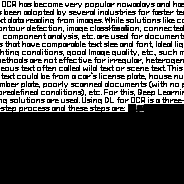

In [72]:
get_image(predictions[0])

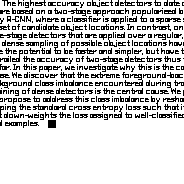

In [67]:
get_image(unpatchify(labels)[0])

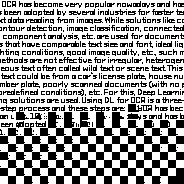

In [73]:
logits, past, loss = model.generate(input_ids=imgs, attention_mask=attention_mask, labels = labels,decoder_attention_mask =decoder_attention_mask )
gen_focal = unpatchify(logits).detach().cpu()
get_image(gen_focal[0])

BCE

In [23]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary_bce'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)


# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "isBinary":True
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)
    

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary_bce and are newly initialized: ['model.mask_token']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.eval()
with torch.no_grad():
    outputs = model(
    input_ids = imgs,
    attention_mask=attention_mask,
    labels = labels,
    decoder_attention_mask = decoder_attention_mask,
    head_mask=None,
    output_attentions=True,
    output_hidden_states=True,
    return_dict=True,
    )

predictions = unpatchify(outputs["logits"]).detach().cpu()

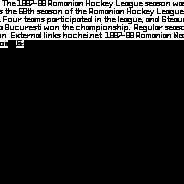

In [25]:
get_image(predictions[0])

In [29]:
binary_pred = (predictions > 0).float()
binary_pred.shape

torch.Size([5, 1, 184, 184])

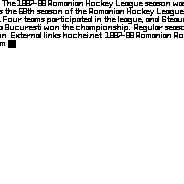

In [52]:
get_image(unpatchify(labels)[0])

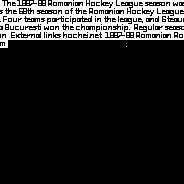

In [32]:
get_image(binary_pred[0])

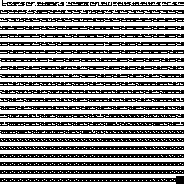

In [26]:
logits, past, loss = model.generate(input_ids=imgs, attention_mask=attention_mask, labels = labels,decoder_attention_mask =decoder_attention_mask )
gen_bce = unpatchify(logits).detach().cpu()
get_image(gen_bce[1])

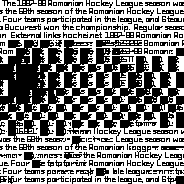

In [34]:
get_image(gen_bce[0])

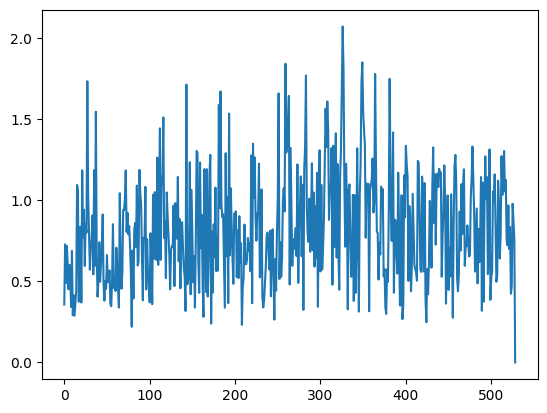

In [27]:
import matplotlib.pyplot as plt

plt.plot(loss[1])

MSE

In [37]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)


# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "isBinary":True
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
model.eval()
with torch.no_grad():
    outputs = model(
    input_ids = imgs,
    attention_mask=attention_mask,
    labels = labels,
    decoder_attention_mask = decoder_attention_mask,
    head_mask=None,
    output_attentions=True,
    output_hidden_states=True,
    return_dict=True,
    )

predictions = unpatchify(outputs["logits"]).detach().cpu()

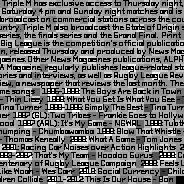

In [39]:
get_image(predictions[1])

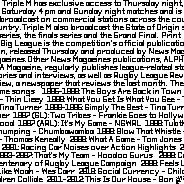

In [40]:
binary_pred = (predictions > 0).float()
get_image(binary_pred[1])

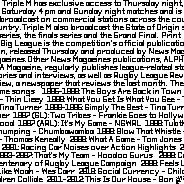

In [41]:
logits, past, loss = model.generate(input_ids=imgs, attention_mask=attention_mask, labels = labels,decoder_attention_mask =decoder_attention_mask )
gen_mse = unpatchify(logits).detach().cpu()
get_image(gen_mse[1])

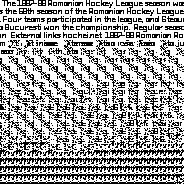

In [43]:
get_image(gen_mse[0])

In [53]:
1+2+3+4+5+6+7+8

36

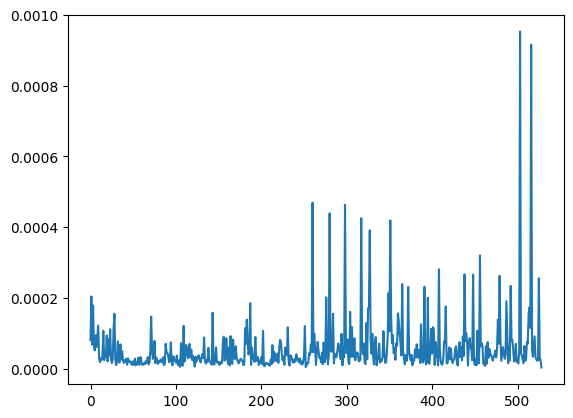

In [42]:
import matplotlib.pyplot as plt

plt.plot(loss[1])

### add mask

In [87]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary_focal'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)


# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0.25,
            "decoder_num_hidden_layers": 12,
            "isBinary":True
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)
   

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary_focal and are newly initialized: ['model.mask_token']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### without unshuffling

zero mask

In [80]:
model.eval()
with torch.no_grad():
    outputs = model(
    input_ids = imgs,
    attention_mask=attention_mask,
    labels = labels,
    decoder_attention_mask = decoder_attention_mask,
    head_mask=None,
    output_attentions=True,
    output_hidden_states=True,
    return_dict=True,
    )

predictions = unpatchify(outputs["logits"]).detach().cpu()

In [76]:
attention_mask=torch.bitwise_and(mask == 0, attention_mask == 1).long()

In [74]:
mask[1]

tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 

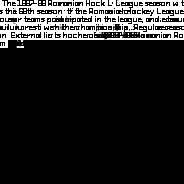

In [81]:
get_image(predictions[0])

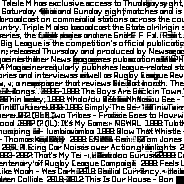

In [82]:
get_image(predictions[1])

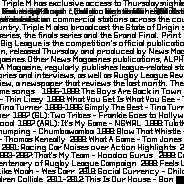

In [33]:
get_image(predictions[1])

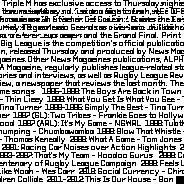

In [64]:
binary_pred = (predictions >0).float()
get_image(binary_pred[1])

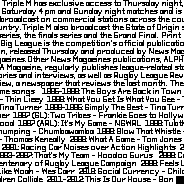

In [14]:
get_image(predictions[1])

In [16]:
imgs.shape

torch.Size([5, 1, 8, 4232])

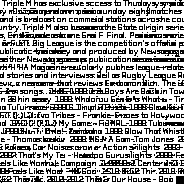

In [83]:
logits, past, loss = model.generate(input_ids=imgs,
                                    attention_mask=attention_mask,
                                    labels = labels,
                                    decoder_attention_mask =decoder_attention_mask )
gen_focal = unpatchify(logits).detach().cpu()
get_image(gen_focal[1])


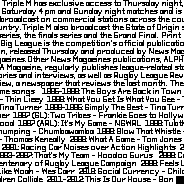

In [62]:
get_image(unpatchify(labels)[1])

0.15 mask

In [19]:
model.eval()
with torch.no_grad():
    outputs = model(
    input_ids = imgs,
    attention_mask=attention_mask,
    labels = labels,
    decoder_attention_mask = decoder_attention_mask,
    head_mask=None,
    output_attentions=True,
    output_hidden_states=True,
    return_dict=True,
    )

predictions = unpatchify(outputs["logits"]).detach().cpu()

ValueError: Attention mask should be of size (5, 1, 529, 449), but is torch.Size([5, 1, 529, 529])

In [14]:
hidden_states = model.model.vit.embeddings.patch_embeddings(imgs)

In [69]:
embedding_output, atten_mask, mask, ids_restore = model.model.vit.embeddings(imgs, attention_mask)

In [34]:
attention_mask[0].sum(),len(attention_mask[0])

(tensor(117.), 529)

In [35]:
mask[0].sum(), len(mask[0])

(tensor(0.), 529)

In [31]:
embedding_output.shape

torch.Size([5, 450, 768])

In [36]:
atten_mask[0].sum(),len(atten_mask[0])

(tensor(118.), 530)

In [40]:
x = _expand_mask(attention_mask, torch.float, 529)

In [22]:
latent = embeddings
latent = torch.gather(latent, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, latent.shape[2]))
latent

tensor([[[-0.1042, -0.0072,  0.0360,  ...,  0.6658,  0.7520,  0.6984],
         [ 0.6348,  0.5117,  0.7322,  ...,  0.6843,  0.7877,  0.7894],
         [ 0.6110,  0.9188,  1.0514,  ...,  0.5096,  0.6673,  0.7427],
         ...,
         [ 0.8697,  0.3021, -0.4987,  ...,  0.6549,  0.6378,  0.5896],
         [ 0.8509,  0.9187,  0.2421,  ...,  0.6789,  0.6476,  0.5861],
         [ 0.1077,  0.8471,  0.8117,  ...,  0.7089,  0.6043,  0.5787]],

        [[-0.0342,  0.0733,  0.0342,  ...,  0.6879,  0.6992,  0.6575],
         [ 0.7576,  0.5399,  0.9315,  ...,  0.7531,  0.6451,  0.6587],
         [ 0.6428,  0.6801,  0.9471,  ...,  0.6617,  0.8085,  0.8716],
         ...,
         [ 0.8360,  0.2482, -0.3956,  ...,  0.5239,  0.7499,  0.7182],
         [ 0.8543,  0.7342,  0.2144,  ...,  0.7160,  0.6596,  0.7550],
         [ 0.0268,  0.6001,  0.8133,  ...,  0.8255,  0.7276,  0.8578]],

        [[-0.0412, -0.0055,  0.0711,  ...,  0.7069,  0.7007,  0.7654],
         [ 0.6826,  0.4708,  0.7790,  ...,  0

In [88]:
model.eval()
with torch.no_grad():
    encoder_outputs = model.model.vit(
    imgs,
    attention_mask=attention_mask,
    head_mask=None,
    output_attentions=True,
    output_hidden_states=True,
    return_dict=True,
    )


In [89]:
latent = encoder_outputs.last_hidden_state
ids_restore = encoder_outputs.ids_restore
mask = encoder_outputs.mask

latent.shape, ids_restore.shape,mask.shape

(torch.Size([5, 397, 768]), torch.Size([5, 529]), torch.Size([5, 529]))

In [90]:
mask[0]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 1., 

In [92]:
# append mask tokens to sequence
mask_tokens = model.model.mask_token.repeat(latent.shape[0], ids_restore.shape[1] + 1 - latent.shape[1], 1)
latent = torch.cat([latent[:, 1:, :], mask_tokens], dim=1)
latent = torch.gather(latent, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, latent.shape[2])) 

In [91]:
encoder_attention_mask = torch.bitwise_and(mask == 0, attention_mask == 1).long()

In [100]:
encoder_attention_mask[0][9]

tensor(0)

In [83]:



# append mask tokens to sequence
mask_tokens = self.mask_token.repeat(latent.shape[0], ids_restore.shape[1] + 1 - latent.shape[1], 1)
latent = torch.cat([latent[:, 1:, :], mask_tokens], dim=1)  # no cls token
# unshuffle
latent = torch.gather(latent, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, latent.shape[2])) 

# merge span mask and padding mask when doing cross attention
encoder_attention_mask = torch.bitwise_and(mask == 0, attention_mask == 1).long()

odict_keys(['last_hidden_state', 'mask', 'ids_restore', 'hidden_states', 'attentions'])

In [118]:
merged_mask = torch.bitwise_and(mask == 1, attention_mask == 1).long()

In [ ]:
merged_mask = torch.bitwise_and(mask == 1, attention_mask == 1).long()

In [50]:
merged_mask = torch.bitwise_and(mask == 0, attention_mask == 1).long()

In [52]:
merged_mask[0]

tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [49]:
mask = outputs.mask
mask[0]

tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [113]:
latent = outputs.last_hidden_state
ids_restore = outputs.ids_restore
mask = outputs.mask

In [114]:
latent[0]

tensor([[-2.9744e-01,  2.6581e-01,  6.1105e-01,  ...,  8.2774e-01,
         -3.6340e-01,  2.9242e-01],
        [ 5.6634e-01,  6.8434e-01,  1.1075e+00,  ..., -6.3359e-01,
         -2.0903e-01,  1.4332e-01],
        [ 4.6723e-01, -5.8347e-01,  1.6708e+00,  ...,  7.2092e-01,
          2.0381e-01, -5.9044e-02],
        ...,
        [-3.5988e-01, -6.4894e-01, -2.4158e-01,  ...,  1.2949e-01,
         -4.0371e-04, -1.5510e-01],
        [-1.5361e+00, -5.6459e-01,  8.1638e-01,  ..., -5.6135e-01,
         -3.4323e-01,  9.4682e-02],
        [-1.5033e+00, -4.5387e-01,  7.6227e-01,  ..., -5.6580e-01,
         -1.8056e-01,  2.0823e-01]])

In [23]:
mask[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [115]:
mask_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))
batch_size = latent.shape[0]

# append mask tokens to sequence
mask_tokens = mask_token.repeat(latent.shape[0], ids_restore.shape[1] + 1 - latent.shape[1], 1)
latent = torch.cat([latent[:, 1:, :], mask_tokens], dim=1)  # no cls token
latent = torch.gather(latent, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, latent.shape[2]))  # unshuffle


In [112]:
ids_restore.shape[1] + 1 - latent.shape[1]

0

In [117]:
latent[0]

torch.Size([529, 768])

### generate

#### 30000

In [430]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-30000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

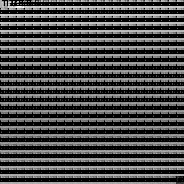

In [431]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

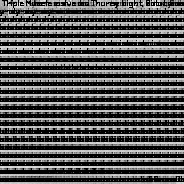

In [432]:
get_image(gen[1])

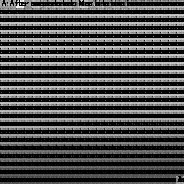

In [433]:
get_image(gen[2])

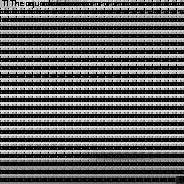

In [434]:
get_image(gen[3])

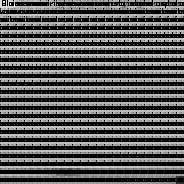

In [435]:
get_image(gen[4])

#### 60000

In [ ]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-60000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

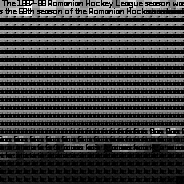

In [375]:
#60000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

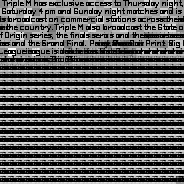

In [376]:
get_image(gen[1])

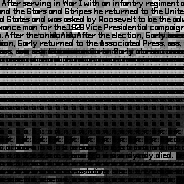

In [377]:
get_image(gen[2])

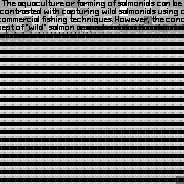

In [378]:
get_image(gen[3])

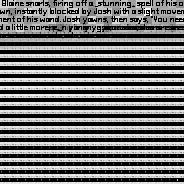

In [379]:
get_image(gen[4])

#### 65000

In [380]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-65000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary/checkpoint-65000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


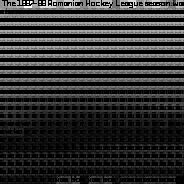

In [381]:

logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

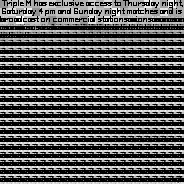

In [382]:
get_image(gen[1])

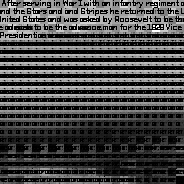

In [383]:
get_image(gen[2])

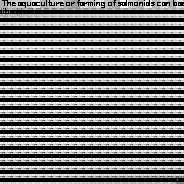

In [384]:
get_image(gen[3])

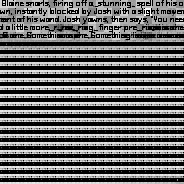

In [385]:
get_image(gen[4])

#### 70000

In [386]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-70000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary/checkpoint-70000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


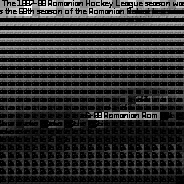

In [387]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

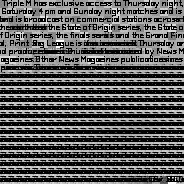

In [388]:
get_image(gen[1])

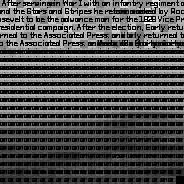

In [389]:
get_image(gen[2])

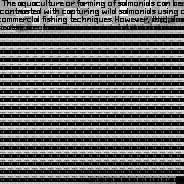

In [390]:
get_image(gen[3])

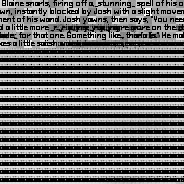

In [391]:
get_image(gen[4])

#### 75000

In [392]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-75000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary/checkpoint-75000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


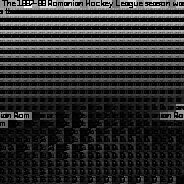

In [393]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

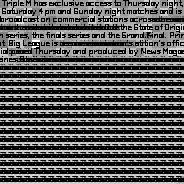

In [394]:
get_image(gen[1])

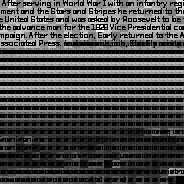

In [395]:
get_image(gen[2])

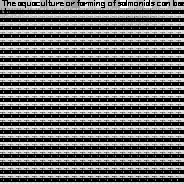

In [396]:
get_image(gen[3])

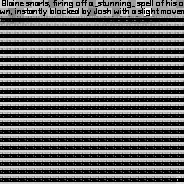

In [397]:
get_image(gen[4])

#### 80000

In [398]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-80000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary/checkpoint-80000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


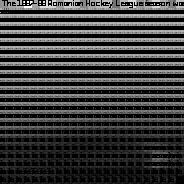

In [399]:
#80000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

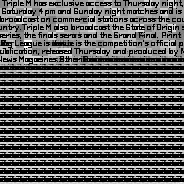

In [400]:
get_image(gen[1])

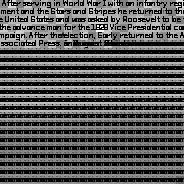

In [401]:
get_image(gen[2])

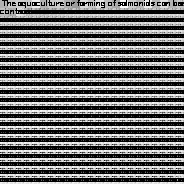

In [402]:
get_image(gen[3])

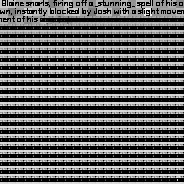

In [403]:
get_image(gen[4])

#### 85000

In [406]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-85000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary/checkpoint-85000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


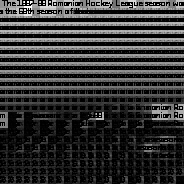

In [407]:
#85000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

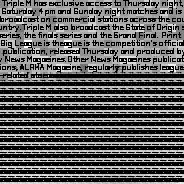

In [408]:
get_image(gen[1])

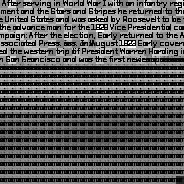

In [409]:
get_image(gen[2])

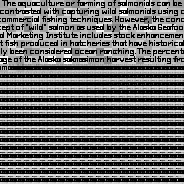

In [410]:
get_image(gen[3])

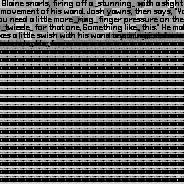

In [411]:
get_image(gen[4])

#### 90000

In [412]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-90000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary/checkpoint-90000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


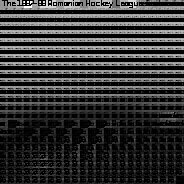

In [413]:
#90000
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

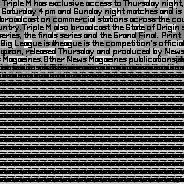

In [414]:
get_image(gen[1])

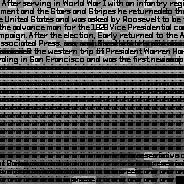

In [415]:
get_image(gen[2])

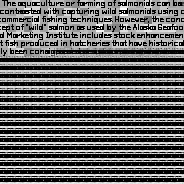

In [416]:
get_image(gen[3])

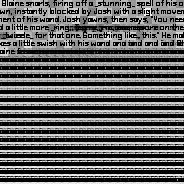

In [417]:
get_image(gen[4])

#### 95000

In [418]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-95000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary/checkpoint-95000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


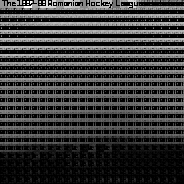

In [419]:

logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

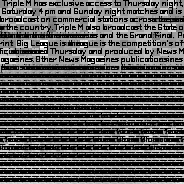

In [420]:
get_image(gen[1])

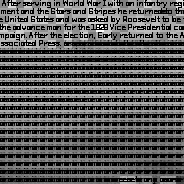

In [421]:
get_image(gen[2])

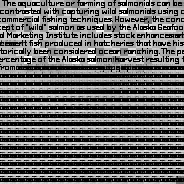

In [422]:
get_image(gen[3])

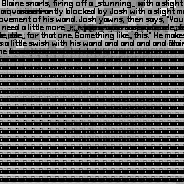

In [423]:
get_image(gen[4])

#### 100000

In [424]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary/checkpoint-100000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained('../experiment/pretrain_bart')

# config
config = PIXELConfig.from_pretrained(
    model_path
)
config.update(
        {
            "mask_ratio": 0,
            "decoder_num_hidden_layers": 12,
            "decoder_intermediate_size": 3072,
            "num_channels":1,
            "vocab_size": 64,
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary/checkpoint-100000/ were not used when initializing BartForConditionalGeneration: ['model.gpt.embed_tokens.weight', 'model.shared.weight']
- This IS expected if you are initializing BartForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


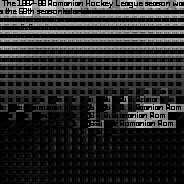

In [425]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[0])

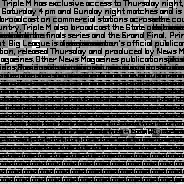

In [426]:
get_image(gen[1])

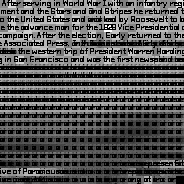

In [427]:
get_image(gen[2])

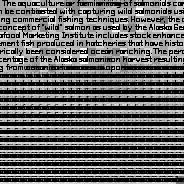

In [428]:
get_image(gen[3])

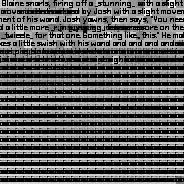

In [429]:
get_image(gen[4])

### generate

In [27]:
def generate(
    #self,
    input_ids = None,
    prompt_len = 0,
    attention_mask = None,
    decoder_input_ids = None,
    encoder_outputs = None,
    decoder_inputs_embeds = None,
    past_key_values = None,
    max_seq_length = None,
    labels = None,
    decoder_attention_mask = None,
    ):
    r'''
    to generate the logits in a autoregressive manner
    here we generate it patch by patch
    the sos token tensor is the same we use during the training
    
    output:
            output_logits -> [BSZ, max_seq_length, patch_size*2*n_channels]:
                this can be unpatchify to [BSZ, n_channels, H, W] to get the imgs
            past_key_values -> tuple:
                saved key values tensors to accelerate sequential decoding
    '''
    if not max_seq_length:
        # adjust this due to the limitation of the positional embeddings
        max_seq_length = model.config.max_position_embeddings - prompt_len
        
    batch_size = input_ids.shape[0]
    if decoder_inputs_embeds is None and decoder_input_ids is None:
        # init start of sentence token
        # shape [BSZ, 1, hidden_size]
        pre_patch = nn.Parameter(torch.zeros(1, 1, model.config.hidden_size))
        pre_patch = pre_patch.expand(batch_size, -1, -1)
    elif decoder_input_ids is not None:
        # prepare prompt
        decoder_inputs_embeds= model.model.vit.embeddings.patch_embeddings(decoder_input_ids)
        # [N, L, hidden_size]
        # add one start patch
        batch_size, _, _ = decoder_inputs_embeds.shape
        sos_token = nn.Parameter(torch.zeros(1, 1, model.config.hidden_size)).to(decoder_inputs_embeds.device)
        sos_tokens = sos_token.expand(decoder_inputs_embeds.shape[0], -1, -1)
        # here the decoder_input_ids is the prompt, we don't need to remove the last embed
        pre_patch = torch.concat((sos_tokens, decoder_inputs_embeds[:,:prompt_len,:]), dim = 1)
        
    if not encoder_outputs:
        encoder_outputs = model.model.vit(
            input_ids,
            attention_mask
        )
        encoder_outputs = BaseModelOutput(
            last_hidden_state=encoder_outputs.last_hidden_state,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions
            )
    
    # to keep track of the generate patch
    patch_size = model.model.vit.embeddings.patch_embeddings.patch_size[0]
    
    if decoder_input_ids is not None:
        output_logits = model.patchify(decoder_input_ids)[:,:prompt_len,:]
    else:
        output_logits = None
    # set eval mode to model to avoid drop out
    model.eval()
    with torch.no_grad():
        for _ in range(max_seq_length):
            outputs = model.forward(
                encoder_outputs = encoder_outputs,
                decoder_inputs_embeds = pre_patch,
                use_cache = True,
                past_key_values = past_key_values
                )
            # get next token output
            pre_patch = outputs.logits[:,-1,:].reshape(batch_size, 1, -1)
            
            # binarize the generated tokens
            if True:
                pre_patch = (pre_patch > 0).float()
            # record the patch
            if output_logits is None:
                output_logits = pre_patch
            else:
                output_logits = torch.cat([output_logits, pre_patch], dim = 1)
            # change it to patch embeddings
            pre_patch = model.unpatchify(pre_patch)
            pre_patch = model.model.vit.embeddings.patch_embeddings\
                .projection(pre_patch).flatten(2).transpose(1, 2)
            past_key_values = outputs.past_key_values
    
    if labels is not None:
        labels = labels.to(output_logits.device)
        # forward loss copied from PIXELForPretraining
        if model.config.norm_pix_loss:
            mean = labels.mean(dim=-1, keepdim=True)
            var = labels.var(dim=-1, keepdim=True)
            labels = (labels - mean) / (var + 1.0e-6) ** 0.5

        loss = (output_logits - labels) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch
        if decoder_attention_mask is not None:
            loss =  loss * decoder_attention_mask
        
        return output_logits, past_key_values, loss
    else:
        return output_logits, past_key_values, _

In [39]:
# for test and visual
model_path = '../experiment/pretrain_bart_BSZ128_binary_focal'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)

# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0.15,
            "decoder_num_hidden_layers": 12,
            "isBinary":True
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at ../experiment/pretrain_bart_BSZ128_binary_focal and are newly initialized: ['model.mask_token']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


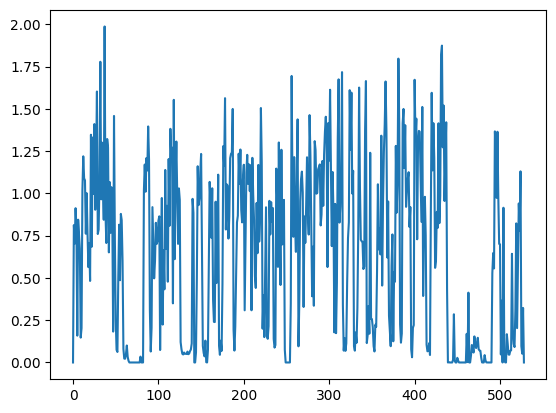

In [44]:
import matplotlib.pyplot as plt

plt.plot(loss[1])

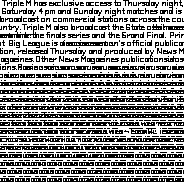

In [25]:
logits = (logits > 0).float()
gen = unpatchify(logits).detach().cpu()
get_image(gen[1])

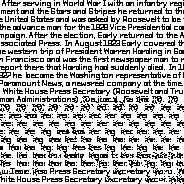

In [29]:
logits, past, loss = model.generate(input_ids=imgs, attention_mask=attention_mask, labels = labels,decoder_attention_mask =decoder_attention_mask )
gen3 = unpatchify(logits).detach().cpu()
get_image(gen3[2])

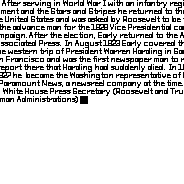

In [33]:
get_image(unpatchify(labels)[2])

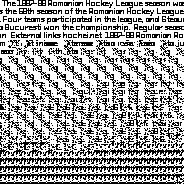

In [32]:
get_image(gen3[0])

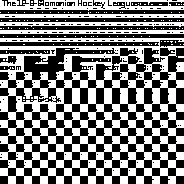

In [47]:
get_image(gen2[0])

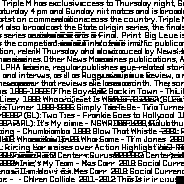

In [46]:
logits, past, loss =model.generate(input_ids=imgs, attention_mask=attention_mask, labels = labels,decoder_attention_mask =decoder_attention_mask )
gen2 = unpatchify(logits).detach().cpu()
get_image(gen2[1])

20

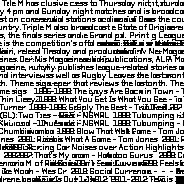

In [42]:
logits, past ,loss =model.generate(input_ids=imgs,
                             attention_mask=attention_mask,
                             decoder_input_ids = imgs, 
                             prompt_len=0,
                             labels = labels,
                             decoder_attention_mask =decoder_attention_mask)
gen0 = unpatchify(logits).detach().cpu()
get_image(gen0[1])

In [43]:
plt.plot(loss)

KeyboardInterrupt: 

In [ ]:
!!! 注意这里是没shuffle的！

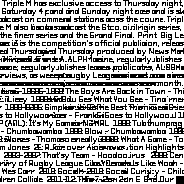

In [41]:
logits, past ,loss =model.generate(input_ids=imgs,
                             attention_mask=attention_mask,
                             decoder_input_ids = imgs, 
                             prompt_len=20,
                             labels = labels,
                             decoder_attention_mask =decoder_attention_mask)
gen20 = unpatchify(logits).detach().cpu()
get_image(gen20[1])

In [ ]:
logits, past ,loss =model.generate(input_ids=imgs,
                             attention_mask=attention_mask,
                             decoder_input_ids = imgs, 
                             prompt_len=20,
                             labels = labels,
                             decoder_attention_mask =decoder_attention_mask)
gen20 = unpatchify(logits).detach().cpu()
get_image(gen20[1])

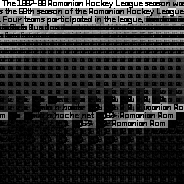

In [71]:
get_image(gen20[0])

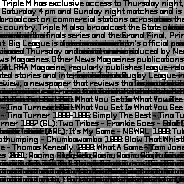

In [67]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=10)
gen10 = unpatchify(logits).detach().cpu()
get_image(gen10[1])

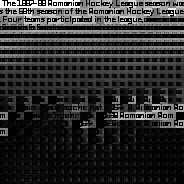

In [68]:
get_image(gen10[0])

5

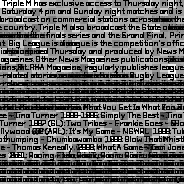

In [65]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=5)
gen5 = unpatchify(logits).detach().cpu()
get_image(gen5[1])

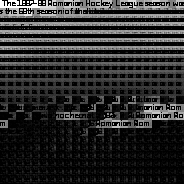

In [66]:
get_image(gen5[0])

0

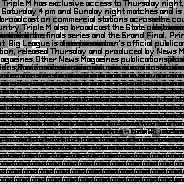

In [63]:
logits, past =model.generate(input_ids=imgs, attention_mask=attention_mask,decoder_input_ids = imgs, prompt_len=0)
gen = unpatchify(logits).detach().cpu()
get_image(gen[1])

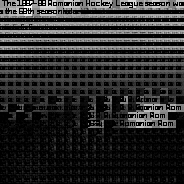

In [64]:
get_image(gen[0])

### Plot loss

Binary-MSE

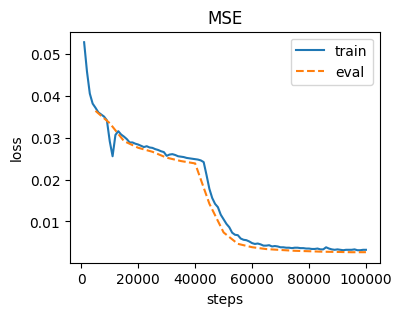

In [2]:
import json
import matplotlib.pyplot as plt
path = '../experiment/unshuffle/pretrain_bart_BSZ128_binary_focal/trainer_state.json'
with open(path, 'r') as fin:
    states = json.load(fin)
    
log_history = states['log_history']

train_loss = []
train_step = []
eval_loss = []
eval_step = []

for sample in log_history:
    if 'loss' in sample.keys():
        train_loss.append(sample['loss'])
        train_step.append(sample['step'])
    elif 'eval_loss' in sample.keys():
        eval_loss.append(sample['eval_loss'])
        eval_step.append(sample['step'])



plt.figure(figsize=(4,3))
plt.plot(train_step,train_loss,label ='train' )
plt.plot(eval_step,eval_loss,'--',label = 'eval')
plt.title("MSE")
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

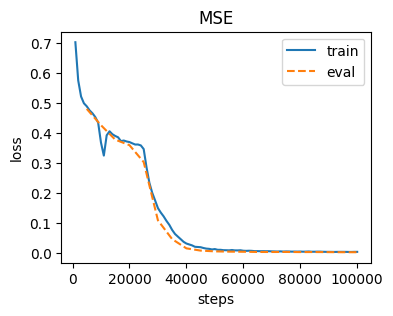

In [48]:
import json
import matplotlib.pyplot as plt
path = '../experiment/pretrain_bart_BSZ128_binary/trainer_state.json'
with open(path, 'r') as fin:
    states = json.load(fin)
    
log_history = states['log_history']

train_loss = []
train_step = []
eval_loss = []
eval_step = []

for sample in log_history:
    if 'loss' in sample.keys():
        train_loss.append(sample['loss'])
        train_step.append(sample['step'])
    elif 'eval_loss' in sample.keys():
        eval_loss.append(sample['eval_loss'])
        eval_step.append(sample['step'])



plt.figure(figsize=(4,3))
plt.plot(train_step,train_loss,label ='train' )
plt.plot(eval_step,eval_loss,'--',label = 'eval')
plt.title("MSE")
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

Binary-bce

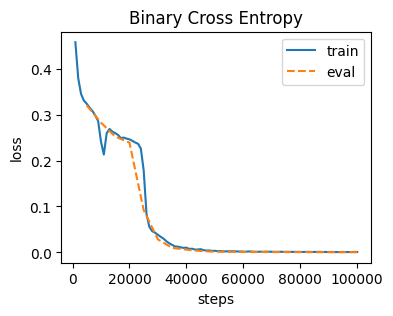

In [49]:
import json
import matplotlib.pyplot as plt
path = '../experiment/pretrain_bart_BSZ128_binary_bce/trainer_state.json'
with open(path, 'r') as fin:
    states = json.load(fin)
    
log_history = states['log_history']

train_loss = []
train_step = []
eval_loss = []
eval_step = []

for sample in log_history:
    if 'loss' in sample.keys():
        train_loss.append(sample['loss'])
        train_step.append(sample['step'])
    elif 'eval_loss' in sample.keys():
        eval_loss.append(sample['eval_loss'])
        eval_step.append(sample['step'])



plt.figure(figsize=(4,3))
plt.plot(train_step,train_loss,label ='train' )
plt.plot(eval_step,eval_loss,'--',label = 'eval')
plt.title("Binary Cross Entropy")
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

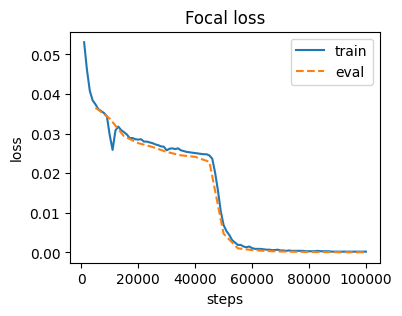

In [50]:
import json
import matplotlib.pyplot as plt
path = '../experiment/pretrain_bart_BSZ128_binary_focal/trainer_state.json'
with open(path, 'r') as fin:
    states = json.load(fin)
    
log_history = states['log_history']

train_loss = []
train_step = []
eval_loss = []
eval_step = []

for sample in log_history:
    if 'loss' in sample.keys():
        train_loss.append(sample['loss'])
        train_step.append(sample['step'])
    elif 'eval_loss' in sample.keys():
        eval_loss.append(sample['eval_loss'])
        eval_step.append(sample['step'])



plt.figure(figsize=(4,3))
plt.plot(train_step,train_loss,label ='train' )
plt.plot(eval_step,eval_loss,'--',label = 'eval')
plt.title("Focal loss")
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

Binary-focal

### OCR

In [55]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
ocr = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.transforms import Compose, InterpolationMode, Lambda, Normalize, Resize, ToTensor
from PIL import Image

img = unpatchify(logits)[1]
#img = model.unpatchify(predictions[:,-20:,:])[1]
transform = Compose([Resize((320,320)),T.ToPILImage()])
img = transform(img)
#img = img.convert("RGB")

In [39]:
import easyocr as ocr  #OCR
reader = ocr.Reader(['en'],model_storage_directory='.')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


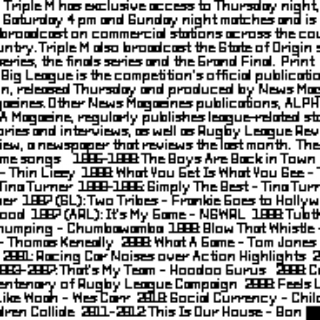

In [38]:
img

In [40]:
import numpy as np
result = reader.readtext(np.array(img))

result_text = [] #empty list for results


for text in result:
    result_text.append(text[1])

In [26]:
from paddleocr import PaddleOCR,draw_ocr
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `fr`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory
#img_path = './imgs_en/img_12.jpg'
#img = logits[0].detach().numpy()
result = ocr.ocr(img, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

[2023/07/18 14:31:52] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/sc118/sc118/xliao11/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/sc118/sc118/xliao11/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

AssertionError: 

In [ ]:
from paddleocr import PaddleOCR,draw_ocr
# Paddleocr supports Chinese, English, French, German, Korean and Japanese.
# You can set the parameter `lang` as `ch`, `en`, `fr`, `german`, `korean`, `japan`
# to switch the language model in order.
ocr = PaddleOCR(use_angle_cls=True, lang='en') # need to run only once to download and load model into memory
img_path = './imgs_en/img_12.jpg'
result = ocr.ocr(img_path, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)


# draw result
from PIL import Image
result = result[0]
image = Image.open(img_path).convert('RGB')
boxes = [line[0] for line in result]
txts = [line[1][0] for line in result]
scores = [line[1][1] for line in result]
im_show = draw_ocr(image, boxes, txts, scores, font_path='./fonts/simfang.ttf')
im_show = Image.fromarray(im_show)
im_show.save('result.jpg')

# GPT

In [ ]:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
loss = outputs.loss
logits = outputs.logits

Downloading: 100%|██████████| 665/665 [00:00<00:00, 2.31MB/s]
Downloading: 100%|██████████| 0.99M/0.99M [00:00<00:00, 3.23MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 1.89MB/s]
Downloading: 100%|██████████| 1.29M/1.29M [00:00<00:00, 3.40MB/s]
Downloading: 100%|██████████| 523M/523M [00:11<00:00, 46.5MB/s] 


In [ ]:
outputs.logits

CausalLMOutputWithCrossAttentions(loss=tensor(3.9902, grad_fn=<NllLossBackward0>), logits=tensor([[[ -35.2362,  -35.3266,  -38.9753,  ...,  -44.4645,  -43.9974,
           -36.4580],
         [-112.6171, -114.5832, -116.5725,  ..., -119.0128, -118.8059,
          -111.6917],
         [ -88.7435,  -89.8644,  -93.1977,  ...,  -92.3839,  -96.1782,
           -92.1273],
         [ -85.1646,  -88.3379,  -92.8703,  ...,  -99.8017,  -94.7657,
           -90.9330],
         [-116.7280, -119.3949, -121.7259,  ..., -129.1003, -124.6102,
          -121.6092],
         [ -77.4425,  -80.4462,  -88.0497,  ...,  -96.2564,  -93.6345,
           -84.0666]]], grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-1.2526,  2.3200,  0.1722,  ..., -1.0076, -0.1897,  1.3219],
          [-1.6482,  3.0222,  1.2789,  ..., -0.9078, -1.7395,  2.4237],
          [-1.8892,  2.4222,  2.5229,  ..., -1.4062, -1.9514,  1.7598],
          [-1.4859,  3.7323,  1.5158,  ..., -1.4985, -1.9235,  2.0859],
          [-

# ImageGPT

/work/sc118/sc118/xliao11/miniconda3/envs/pixel-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1721537/3387176047.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(context).to(device)


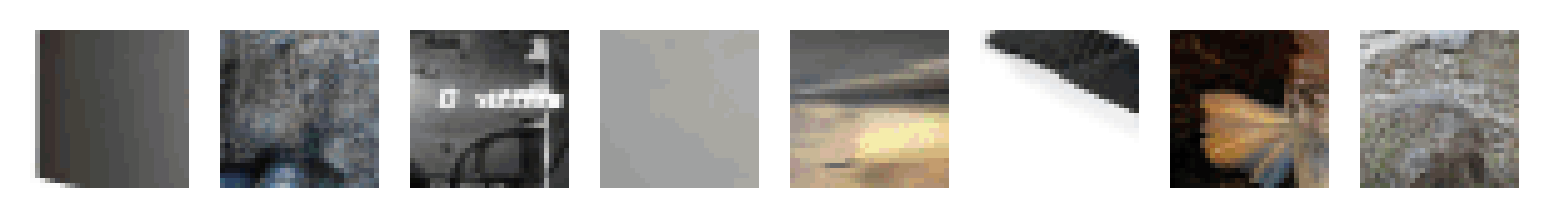

In [ ]:
from transformers import ImageGPTFeatureExtractor, ImageGPTForCausalImageModeling
import torch
import matplotlib.pyplot as plt
import numpy as np

feature_extractor = ImageGPTFeatureExtractor.from_pretrained("openai/imagegpt-small")
model = ImageGPTForCausalImageModeling.from_pretrained("openai/imagegpt-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# unconditional generation of 8 images
batch_size = 8
context = torch.full((batch_size, 1), model.config.vocab_size - 1)  # initialize with SOS token
context = torch.tensor(context).to(device)
output = model.generate(
    input_ids=context, max_length=model.config.n_positions + 1, temperature=1.0, do_sample=True, top_k=40
)

clusters = feature_extractor.clusters
n_px = feature_extractor.size

samples = output[:, 1:].cpu().detach().numpy()
samples_img = [
    np.reshape(np.rint(127.5 * (clusters[s] + 1.0)), [n_px, n_px, 3]).astype(np.uint8) for s in samples
]  # convert color cluster tokens back to pixels
f, axes = plt.subplots(1, batch_size, dpi=300)

for img, ax in zip(samples_img, axes):
    ax.axis("off")
    ax.imshow(img)

In [ ]:
context.shape

torch.Size([8, 1])

In [ ]:
context[0]

tensor([512])

In [ ]:
samples.shape 

(8, 1024)

In [ ]:
samples_img[0].shape

(32, 32, 3)

# TROCR

In [54]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
ocr = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")



Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
# load image from the IAM dataset
url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values

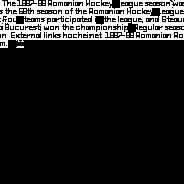

In [95]:
get_image(binary_pred[0])

In [130]:
labels.shape, logits.shape

(torch.Size([5, 529, 64]), torch.Size([5, 529, 64]))

In [71]:
img = model.unpatchify(logits[:,-20:,:])[2]
img = (img > 0).float()
get_image(img)

In [73]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image

img = model.unpatchify(labels[:,:20,:])[1]
#img = model.unpatchify(predictions[:,-20:,:])[1]
transform = T.ToPILImage()
img = transform(img)
img = img.convert("RGB")

In [74]:
img

In [75]:

pixel_values = processor(img, return_tensors="pt").pixel_values
generated_ids = ocr.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


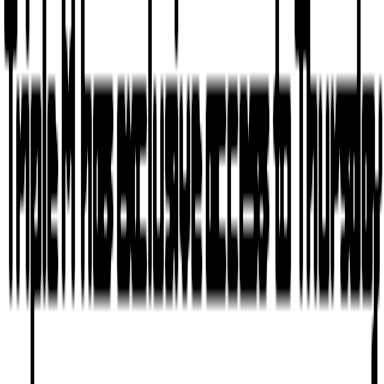

In [81]:
get_image(pixel_values[0])

In [76]:
generated_text

'THIPLE M HAS EXCLUSIVE ACCESS TO THURSDAY'

In [251]:
word = []
image = model.unpatchify(labels[:,:120,:])[1]
for i in range(0,3):
    slice = image[:,:, 8*i*40:8*(i+1)*40]
    pixel_values = processor(slice, return_tensors="pt").pixel_values
    generated_ids = ocr.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    word.append(generated_text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [252]:
word

['TRIPLE M HAS EXCLUSIVE ACCESS TO THURSDAY NIGHT, GAT',
 'ICHES AND IS BROADCAST ON COMMERCIAL STATIONS ACROSS THE COUN',
 'ADJUST THE STATE OF ORIGIN SERIES, THE FINALS SERIES AND THE GRAND']

In [253]:
print("".join(word).lower())

triple m has exclusive access to thursday night, gatiches and is broadcast on commercial stations across the counadjust the state of origin series, the finals series and the grand


In [244]:
image = model.unpatchify(labels[:,:100,:])[1]
slice = image[:,:, :8*40]
pixel_values = processor(slice, return_tensors="pt").pixel_values
generated_ids = ocr.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [245]:
generated_text.lower()

'triple m has exclusive access to thursday night, gat'

In [240]:
image = model.unpatchify(labels[:,:100,:])[1]
slice = image[:,:, :8*20]
get_image(slice)

In [213]:
word

['TRAILED RES ROMOUNT',
 '1 BOOKLY LANGUASES',
 'WALANCE INCLUSIVE RECEIPT',
 'MARTIER SOMMINAL NO',
 'CHANGE, COME AGAIN, PRIMARY,',
 'SME FORGANIZEDES ENCH',
 'E BACK OF RECEIPT FOR AN OFFER',
 '***',
 'AMPLEMENT IS REQUIRED :',
 'EPSON SETEMAD LINKS']

In [215]:
print(''.join(word).lower())

trailed res romount1 bookly languaseswalance inclusive receiptmartier somminal nochange, come again, primary,sme forganizedes enche back of receipt for an offer***amplement is required :epson setemad links


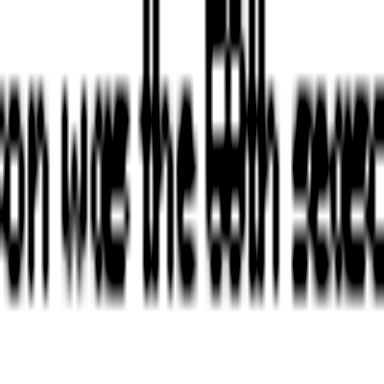

In [193]:
input = model.unpatchify(labels[:,20:30,:])[0]
pixel_values = processor(input, return_tensors="pt").pixel_values
get_image(pixel_values[0])


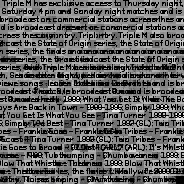

In [187]:
get_image(gen[1])

In [188]:
gen[1].shape

torch.Size([3, 184, 184])

In [194]:
generated_ids = ocr.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


ON WAS THE 99TH SECRET


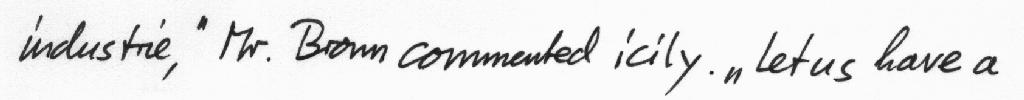

In [170]:
image

In [142]:
test = processor(gen[1], return_tensors="pt").pixel_values

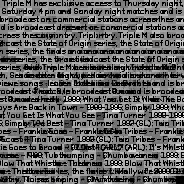

In [146]:
get_image(gen[1])

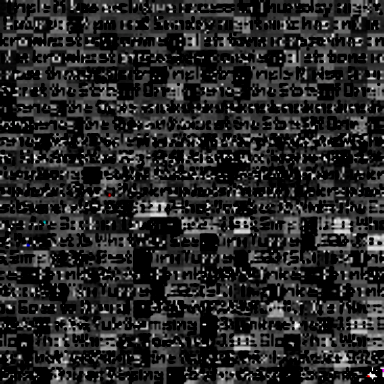

In [145]:
get_image(test[0])

In [139]:
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [148]:
generated_ids = ocr.generate(test)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


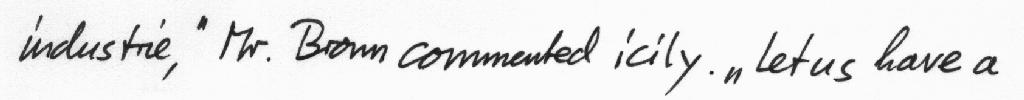

In [ ]:
image

In [ ]:
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [ ]:
generated_ids

tensor([[    2, 21267,  1506,  2156,    22,   427,     4,  1547,  7181, 41591,
          5846,   479,    22,  2780,   201,    33,    10,     2]])

In [149]:
generated_text

'0 0'

## Part of Speech Tagging

In [1]:
import argparse
import logging
import os
import sys
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import transformers
import submitit

from pixel import (
    PIXELConfig,
    BARTForTokenClassification,
    BARTEncoderForTokenClassification,
    UPOS_LABELS,
    Modality,
    PangoCairoTextRenderer,
    PIXELTrainer,
    PIXELTrainingArguments,
    POSDataset,
    Split,
    PyGameTextRenderer,
    get_transforms,
    resize_model_embeddings,
)
from seqeval.metrics import accuracy_score
import torch
from torch import nn
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    EvalPrediction,
    HfArgumentParser,
    PreTrainedTokenizerFast,
    default_data_collator,
    set_seed, PretrainedConfig,
)
from transformers.trainer_utils import get_last_checkpoint, is_main_process

/work/sc118/sc118/xliao11/miniconda3/envs/pixel-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import argparse
import logging
import os
import sys
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import transformers
import wandb
from pixel import (
    AutoConfig,
    AutoModelForTokenClassification,
    UPOS_LABELS,
    Modality,
    PangoCairoTextRenderer,
    PIXELTrainer,
    PIXELTrainingArguments,
    POSDataset,
    Split,
    PyGameTextRenderer,
    get_transforms,
    resize_model_embeddings,
)
from seqeval.metrics import accuracy_score
from torch import nn
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    EvalPrediction,
    HfArgumentParser,
    PreTrainedTokenizerFast,
    default_data_collator,
    set_seed, PretrainedConfig,
)

In [2]:
labels = UPOS_LABELS
label_map: Dict[int, str] = {i: label for i, label in enumerate(labels)}

In [8]:
# for test and visual
model_path = '../experiment/unshuffle/pretrain_bart_BSZ128_binary_focal/checkpoint-95000/'
text_renderer = PyGameTextRenderer.from_pretrained(model_path)


# config
config = PIXELConfig.from_pretrained(
    model_path
)

config.update(
        {
            "mask_ratio": 0.25,
            "decoder_num_hidden_layers": 12,
            "isBinary":True
        }
)

model = BartForConditionalGeneration.from_pretrained(
    model_path,
    config = config
)

NameError: name 'BartForConditionalGeneration' is not defined

In [3]:
model_path = '../experiment/unshuffle/pretrain_bart_BSZ128_binary_focal'
config = PIXELConfig.from_pretrained(
    model_path,
    num_labels=len(labels),
    id2label=label_map,
    label2id={label: i for i, label in enumerate(labels)},
    attention_probs_dropout_prob=0.1,
    hidden_dropout_prob=0.1,
    mask_ratio = 0,
    decoder_num_hidden_layers = 12,
    isBinary = True,
    
)

In [4]:
model = BARTEncoderForTokenClassification.from_pretrained(
    model_path,
    config=config
)

Some weights of the model checkpoint at ../experiment/unshuffle/pretrain_bart_BSZ128_binary_focal were not used when initializing BARTEncoderForTokenClassification: ['model.gpt.layers.10.encoder_attn_layer_norm.bias', 'model.gpt.layers.5.fc2.bias', 'model.gpt.layers.4.self_attn.out_proj.weight', 'model.gpt.layers.10.encoder_attn.q_proj.bias', 'model.gpt.layers.6.fc1.bias', 'model.gpt.layers.1.self_attn.k_proj.weight', 'model.gpt.layers.2.encoder_attn.v_proj.weight', 'model.gpt.layers.10.fc1.bias', 'model.gpt.layers.8.self_attn.q_proj.bias', 'model.gpt.layers.6.self_attn_layer_norm.bias', 'model.gpt.layers.7.fc1.bias', 'model.gpt.layers.5.encoder_attn.k_proj.bias', 'model.gpt.layers.4.encoder_attn.k_proj.bias', 'model.gpt.embed_positions.weight', 'model.gpt.layers.7.fc2.weight', 'model.gpt.layers.11.final_layer_norm.bias', 'model.gpt.layers.2.self_attn.q_proj.bias', 'model.gpt.layers.11.encoder_attn.out_proj.bias', 'model.gpt.layers.8.final_layer_norm.weight', 'model.gpt.layers.3.encode

In [9]:
model_path = '../cache/models/pixel-base/'
config = PIXELConfig.from_pretrained(
    model_path,
    num_labels=len(labels),
    id2label=label_map,
    label2id={label: i for i, label in enumerate(labels)},
    attention_probs_dropout_prob=0.1,
    hidden_dropout_prob=0.1,
    mask_ratio =0,
    
)

model = BARTEncoderForTokenClassification.from_pretrained(
    model_path,
    config=config
)

Some weights of the model checkpoint at ../cache/models/pixel-base/ were not used when initializing BARTEncoderForTokenClassification: ['decoder.decoder_pred.bias', 'decoder.decoder_layers.0.layernorm_after.weight', 'decoder.decoder_layers.3.attention.attention.key.weight', 'decoder.decoder_layers.5.intermediate.dense.bias', 'decoder.decoder_layers.1.layernorm_after.bias', 'decoder.decoder_layers.3.layernorm_after.weight', 'decoder.decoder_layers.7.attention.attention.query.weight', 'decoder.decoder_layers.2.attention.attention.query.weight', 'decoder.decoder_layers.3.attention.attention.query.weight', 'decoder.decoder_layers.6.attention.attention.key.weight', 'decoder.decoder_layers.1.layernorm_before.weight', 'decoder.decoder_layers.4.attention.attention.query.bias', 'decoder.decoder_layers.6.layernorm_after.weight', 'decoder.decoder_layers.1.output.dense.weight', 'decoder.decoder_layers.6.attention.attention.query.weight', 'decoder.decoder_layers.7.layernorm_before.weight', 'decoder

In [15]:
processor = PyGameTextRenderer.from_pretrained(model_path)

In [17]:
from torchvision.transforms import Compose, InterpolationMode, Lambda, Normalize, Resize, ToTensor


transforms = Compose([
        Resize((processor.pixels_per_patch, processor.pixels_per_patch * processor.max_seq_length), interpolation=InterpolationMode.BICUBIC),
        ToTensor(),
        lambda x: x>=1,
        lambda x: x.float(),])


In [18]:
processor.max_seq_length = 256

pos_train = POSDataset(
    data_dir="../cache/datasets/pos/ud-treebanks-v2.10/UD_English-EWT",
    processor=processor,
    transforms=transforms,
    modality=Modality.IMAGE,
    labels=UPOS_LABELS,
    max_seq_length=256,
    overwrite_cache=True,
    mode=Split.TRAIN
)

In [21]:
get_image(pos_train[0]['pixel_values'])

In [23]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    attention_mask = torch.stack([example["attention_mask"] for example in examples])
    dtype = torch.long if type(examples[0]["label_ids"][0]) is int else torch.float
    labels = torch.tensor([example["label_ids"] for example in examples], dtype=dtype)
    inputs = {"pixel_values": pixel_values, "attention_mask": attention_mask, "labels": labels}

    return inputs

In [24]:
test = pos_train[:5]
inputs = collate_fn(test)

In [43]:
model.config.patch_size,model.config.image_size

(8, [8, 4232])

In [25]:
import math

In [26]:
max_seq_length = 256

old_height, old_width = model.config.image_size
patch_size = model.config.patch_size
old_ppr = math.sqrt(old_height * old_width) // patch_size
new_ppr = math.sqrt(max_seq_length)

old_pos_embeds = model.model.vit.embeddings.position_embeddings[:, : max_seq_length + 1, :]
model.model.vit.embeddings.position_embeddings.data = old_pos_embeds.clone()
# Update image_size
new_height = int(new_ppr * patch_size) if old_height == old_width else int(patch_size)
new_width = int(new_ppr * patch_size) if old_height == old_width else int(patch_size * new_ppr ** 2)
model.config.image_size = [new_height, new_width]
model.image_size = [new_height, new_width]
model.model.vit.embeddings.patch_embeddings.image_size = [new_height, new_width]

In [ ]:
def resize_model_embeddings(model, max_seq_length: int) -> None:
    """
    Checks whether position embeddings need to be resized. If the specified max_seq_length is longer than
    the model's number of patches per sequence, the position embeddings will be interpolated.
    If max_seq_length is shorter, the position embeddings will be truncated

    Args:
        model (`ViTForImageClassification`):
            The model for which position embeddings may be resized.
        max_seq_length (`int`):
            The maximum sequence length that determines the number of patches (excluding CLS patch) in the
            model.
    """

    patch_size = model.config.patch_size
    if isinstance(model.config.image_size, tuple) or isinstance(model.config.image_size, list):
        old_height, old_width = model.config.image_size
    else:
        old_height, old_width = (model.config.image_size, model.config.image_size)

    # ppr means patches per row (image is patchified into grid of [ppr * ppr])
    old_ppr = math.sqrt(old_height * old_width) // patch_size
    new_ppr = math.sqrt(max_seq_length)

    if old_ppr < new_ppr:
        # Interpolate position embeddings
        logger.info(f"Interpolating position embeddings to {max_seq_length}")
        model.config.interpolate_pos_encoding = True
    elif old_ppr > new_ppr:
        logger.info(f"Truncating position embeddings to {max_seq_length}")
        # Truncate position embeddings
        old_pos_embeds = model.vit.embeddings.position_embeddings[:, : max_seq_length + 1, :]
        model.vit.embeddings.position_embeddings.data = old_pos_embeds.clone()
        # Update image_size
        new_height = int(new_ppr * patch_size) if old_height == old_width else int(patch_size)
        new_width = int(new_ppr * patch_size) if old_height == old_width else int(patch_size * new_ppr ** 2)
        model.config.image_size = [new_height, new_width]
        model.image_size = [new_height, new_width]
        model.vit.embeddings.patch_embeddings.image_size = [new_height, new_width]

In [61]:
inputs['pixel_values'].shape

torch.Size([5, 1, 8, 2048])

In [64]:
vit_outputs= model.model.vit(pixel_values = inputs['pixel_values'],
                             attention_mask = inputs['attention_mask'])

In [66]:
vit_outputs.keys()

odict_keys(['last_hidden_state', 'mask', 'ids_restore'])

In [22]:
model.config.model_type

'pixel'

In [97]:
outputs= model.model(
    pixel_values = inputs['pixel_values'],
    attention_mask = inputs['attention_mask'],
    decoder_inputs_embeds = model.prepare_decoder_input_embeds(inputs['pixel_values'])
                             )

In [98]:
sequence_output = outputs[0]
sequence_output = model.dropout(sequence_output)
logits = model.classifier(sequence_output)

In [99]:
logits.shape

torch.Size([5, 256, 17])

In [100]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
loss_fct = CrossEntropyLoss()
loss = loss_fct(logits.view(-1, model.num_labels), inputs['labels'].view(-1))

In [90]:
logits.view(-1, model.num_labels).shape

torch.Size([1280, 17])

In [91]:
inputs['labels'].view(-1).shape

torch.Size([1280])

In [93]:
np.argmax(logits.detach().numpy(), axis=2)

array([[12, 15, 15, ...,  7,  7,  7],
       [ 6, 11,  8, ...,  7,  7,  7],
       [ 6,  6, 16, ..., 15,  7,  7],
       [ 0, 10,  5, ..., 15, 15, 15],
       [ 7, 16,  5, ...,  7,  7,  7]])

In [27]:
outputs= model(
    pixel_values = inputs['pixel_values'],
    attention_mask = inputs['attention_mask'],
    labels = inputs['labels']
                             )

AttributeError: 'Seq2SeqModelOutput' object has no attribute 'hidden_states'

# Rendering

In [1]:
from pixel import (
    PIXELConfig,
    PIXELEmbeddings,
    PIXELModel,
    PIXELForPreTraining,
    PIXELTrainerForPretraining,
    SpanMaskingGenerator,
    PyGameTextRenderer,
    get_attention_mask,
    get_transforms,
    get_2d_sincos_pos_embed
)

/work/sc118/sc118/xliao11/miniconda3/envs/pixel-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
text_renderer = PyGameTextRenderer.from_pretrained(model_path)